In [1]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint
import csv

In [2]:
Ad      = 4.4e16
Ed      = 140.06e3
Ap      = 1.7e11/60
Ep      = 16.9e3/0.239
deltaHp = -82.2e3
UA      = 33.3083 #%18.8445;
Qc      = 650
Qs      = 12.41e-2
V       = 0.5
Tc      = 27
Tamb    = 27
Cpc     = 4.184
R       = 8.3145
alpha   = 1.212827
beta    = 0.000267
epsilon = 0.5
theta   = 1.25
m1      = 450
cp1     = 4.184
mjCpj   = (18*4.184)+(240*0.49)
cp2     = 187
cp3     = 110.58 #%J/molK
cp4     = 84.95
m5      = 220
cp5     = 0.49
m6      = 7900
cp6     = 0.49
M0      = 0.7034
I0      = 4.5e-3

# Define Batch Reactor model
def br(x,t,u,Ad):
    # Inputs:
    # Coolant flow rate
    F = u*16.667

    # States (4):
    # Initiator
    Ii  = x[0]
    # Monomer
    M  = x[1]
    # Reactor temperature
    Tr = x[2]
    # Jacket temperature
    Tj = x[3]

    Ri    = Ad*Ii*(np.exp(-Ed/(R*(Tr+273.15))))
    Rp    = Ap*(Ii**epsilon)*(M**(theta)*(np.exp(-Ep/(R*(Tr+273.15)))))
    mrCpr = m1*cp1+ Ii*cp2*V + M*cp3*V +(M0-M)*cp4*V+ m5*cp5 + m6*cp6
    Qpr   = alpha*(Tr-Tc)**beta

    # Computing the rate of change of I, M, Tr, Tj using Differential Equations
    dy1_dt = -Ri
    dy2_dt = -Rp
    dy3_dt = (Rp*V*(-deltaHp)-UA*(Tr-Tj)+Qc+Qs-Qpr)/mrCpr
    dy4_dt = (UA*(Tr-Tj)-F*Cpc*(Tj-Tc))/mjCpj

    # Return xdot:
    xdot = np.zeros(4)
    xdot[0] = dy1_dt
    xdot[1] = dy2_dt
    xdot[2] = dy3_dt
    xdot[3] = dy4_dt

    return xdot



In [3]:

class BR3(gym.Env):

    def __init__(self):
        self.action_space = spaces.Box(low=0.25, high=0.75, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)

        self.t = np.linspace(0, 7200, 7201)
        self.i = 0

        Tr_ref = pd.read_csv('Trajectory2.csv')
        self.a1 = Tr_ref.values.tolist()
        self.sp = self.a1[self.i][0]

        # Initial conditions
        self.I = 4.5e-3
        self.M = 0.7034
        self.Tr = 45.0
        self.Tj = 40.0
        self.state = self.Tr, self.sp

        self.y0 = np.empty(4)
        self.y0[0] = self.I
        self.y0[1] = self.M
        self.y0[2] = self.Tr
        self.y0[3] = self.Tj

        self.time_step = 7200

    def step(self, action):
        action = action[0]
        u = action

        ts = [self.t[self.i], self.t[self.i+1]]
        y = scipy.integrate.odeint(br, self.y0, ts, args=(u, 4.4e16))
        x = np.round(y, decimals=4)

        self.I = x[-1][0]
        self.M = x[-1][1]
        self.Tr = x[-1][2]
        self.Tj = x[-1][3]

        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])

        # Data saving with overwrite logic
        data = [self.sp, self.Tr, self.Tj, action]
        mode = 'w' if self.i == 0 else 'a'
        with open('data.csv', mode, newline='') as file:
            writer = csv.writer(file)
            if self.i == 0:
                writer.writerow(['Setpoint', 'Reactor Temperature', 'Jacket Temperature', 'Action'])
            writer.writerow(data)

        self.i += 1
        if self.i < len(self.a1):
            self.sp = self.a1[self.i][0]

        difference = self.sp - self.Tr
        error = abs(difference)

        # Reward logic
        if error <= 0.5:
            self.reward = +100
        elif error <= 1:
            self.reward = +50
        elif error <= 3:
            self.reward = +25
        elif error <= 4:
            self.reward = +10
        else:
            self.reward = -100

        done = self.i >= self.time_step
        info = {}

        self.state = self.Tr, self.sp
        return self.state, self.reward, done, info

    def reset(self):
        self.I = 4.5e-3
        self.M = 0.7034
        self.Tr = 45.0
        self.Tj = 40.0
        self.i = 0

        self.sp = self.a1[self.i][0]
        self.state = self.Tr, self.sp

        self.y0 = np.array([self.I, self.M, self.Tr, self.Tj])

        return self.state

In [4]:
# GPU/CPU setup
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


C:\Users\arnav\AppData\Local\Temp\ipykernel_25520\2085197315.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training Episodes:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\arnav\AppData\Local\Temp\ipykernel_25520\2085197315.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\arnav\AppData\Local\Temp\ipykernel_25520\2085197315.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training Episodes:   1%|          | 1/100 [00:10<17:59, 10.90s/it]

[Episode 0] Total reward: -687580.000


Training Episodes:  11%|█         | 11/100 [02:00<16:18, 11.00s/it]

[Episode 10] Total reward: -687470.000


Training Episodes:  21%|██        | 21/100 [03:55<15:24, 11.71s/it]

[Episode 20] Total reward: -687470.000


Training Episodes:  31%|███       | 31/100 [05:44<12:34, 10.94s/it]

[Episode 30] Total reward: -687445.000


Training Episodes:  41%|████      | 41/100 [07:34<10:56, 11.12s/it]

[Episode 40] Total reward: -687580.000


Training Episodes:  51%|█████     | 51/100 [09:22<08:53, 10.88s/it]

[Episode 50] Total reward: -687555.000


Training Episodes:  61%|██████    | 61/100 [11:09<06:55, 10.66s/it]

[Episode 60] Total reward: -687445.000


Training Episodes:  71%|███████   | 71/100 [12:57<05:13, 10.79s/it]

[Episode 70] Total reward: -687445.000


Training Episodes:  81%|████████  | 81/100 [14:44<03:24, 10.76s/it]

[Episode 80] Total reward: -687470.000


Training Episodes:  91%|█████████ | 91/100 [16:33<01:36, 10.77s/it]

[Episode 90] Total reward: -687580.000


Training Episodes: 100%|██████████| 100/100 [18:09<00:00, 10.90s/it]


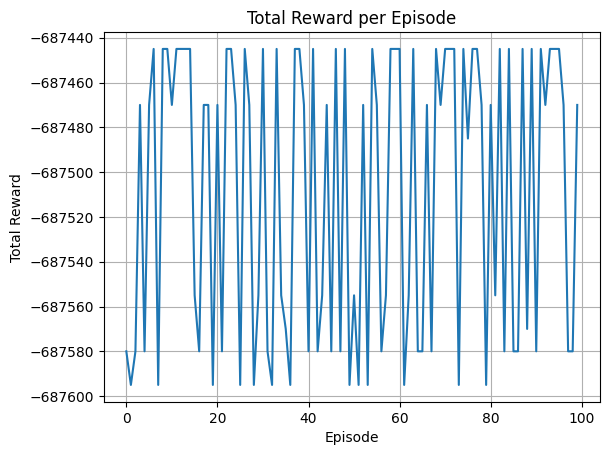

✅ Training complete.
✅ Model saved.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
# --- Same imports, device, etc. as you wrote ---

from __main__ import BR3  # Or import your BR3 class properly

# Actor Network
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, s):
        x = self.relu(self.fc1(s))
        x = self.relu(self.fc2(x))
        action = self.tanh(self.fc3(x)) * 0.25 + 0.5  # Range [0.25, 0.75]
        return action

# Critic Network
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, s, a):
        x = torch.cat([s, a], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize everything
actor = Actor().to(device)
critic = Critic().to(device)
target_actor = deepcopy(actor).to(device)
target_critic = deepcopy(critic).to(device)

replay_buffer = []
optimizer_actor = optim.Adam(actor.parameters(), lr=0.001)
optimizer_critic = optim.Adam(critic.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()

L = 50    # Episodes
T = 7000    # Steps per episode
gamma = 0.99
batch_size = 1024
M = 10      # Gradient updates per episode

env = BR3()
reward_log = []

for episode in tqdm(range(L), desc="Training Episodes"):
    state = env.reset()
    episode_data = []
    total_reward = 0

    for t in range(T):
        s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            a_tensor = actor(s_tensor)
        action = a_tensor.cpu().numpy()[0][0] + np.random.normal(0, 0.02)  # Small exploration noise
        action = np.clip(action, 0.25, 0.75)

        next_state, reward, done, _ = env.step([action])
        episode_data.append((state, [action], reward, next_state))
        state = next_state
        total_reward += reward

        if done:
            break

    reward_log.append(total_reward)

    # Discounted returns
    G = []
    discounted = 0
    for _, _, r, _ in reversed(episode_data):
        discounted = r + gamma * discounted
        G.insert(0, discounted)

    for i, (s, a, _, _) in enumerate(episode_data):
        replay_buffer.append((s, a, G[i]))
        if len(replay_buffer) > 5000:
            replay_buffer.pop(0)

    if len(replay_buffer) >= batch_size:
        for _ in range(M):
            indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
            batch = [replay_buffer[i] for i in indices]

            s_batch = torch.FloatTensor([b[0] for b in batch]).to(device)
            a_batch = torch.FloatTensor([b[1] for b in batch]).to(device)
            g_batch = torch.FloatTensor([b[2] for b in batch]).unsqueeze(-1).to(device)

            # Critic update
            optimizer_critic.zero_grad()
            with torch.cuda.amp.autocast():
                q_pred = critic(s_batch, a_batch)
                critic_loss = nn.MSELoss()(q_pred, g_batch)
            scaler.scale(critic_loss).backward()
            scaler.step(optimizer_critic)
            scaler.update()

            # Actor update
            optimizer_actor.zero_grad()
            with torch.cuda.amp.autocast():
                a_pred = actor(s_batch)
                q_val = critic(s_batch, a_pred)
                actor_loss = -q_val.mean()
            scaler.scale(actor_loss).backward()
            scaler.step(optimizer_actor)
            scaler.update()

            # Soft updates
            with torch.no_grad():
                for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                    target_param.data.copy_(0.001 * param.data + 0.999 * target_param.data)
                for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                    target_param.data.copy_(0.001 * param.data + 0.999 * target_param.data)

    if episode % 10 == 0:
        print(f"[Episode {episode}] Total reward: {total_reward:.3f}")

# Plot reward curve
plt.plot(reward_log)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.savefig("training_plots/reward_curve.png")
plt.show()  

torch.save(actor.state_dict(), "actor_final.pth")
torch.save(critic.state_dict(), "critic_final.pth")

print("✅ Training complete.")
print("✅ Model saved.")
# Save the model


import torch
import torch.nn as nn

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dummy model (increase layer sizes if needed)
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        self.fc1 = nn.Linear(2, 512)  # Increased layer size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, s):
        x = self.relu(self.fc1(s))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x)) * 0.25 + 0.5
        return x

# Initialize model and move to GPU
model = TestModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Get total VRAM
total_vram = torch.cuda.get_device_properties(device).total_memory
max_vram_usage = total_vram * 0.9  # 90% of total VRAM

# Start testing batch sizes
batch_size = 256
max_batch_size = batch_size
while True:
    try:
        # Allocate a batch of input tensors
        dummy_input = torch.randn(batch_size, 2).to(device)
        dummy_target = torch.randn(batch_size, 1).to(device)

        # Forward pass
        output = model(dummy_input)
        loss = criterion(output, dummy_target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Check VRAM usage
        used_vram = torch.cuda.memory_allocated(device)
        print(f"Batch Size: {batch_size}, VRAM Used: {used_vram / (1024**2):.2f} MB")

        # If memory usage is safe, increase batch size
        if used_vram < max_vram_usage:
            max_batch_size = batch_size
            batch_size *= 2  # Double the batch size
        else:
            break  # Stop when we exceed safe VRAM usage

    except RuntimeError as e:
        print(f"Out of memory error at batch size {batch_size}: {e}")
        break

print(f"🚀 Maximum stable batch size: {max_batch_size}")
